# Project 3


### Problem statement:
#### What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?

### Objective

- How can we create a Reddit post that will get the most engagement from Reddit users?

- What would be a compelling story on a Reddit post?


In [479]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

To be able to scrap Reddit, I had to identify the correct tags on Reddit to pull the data from. I used the Developer Tools option on Google Chrome extensively to correctly identify from which tags I need to pull the information. I want to pull from each post to pull the necessary information and then loop it over each page and through each page. In addition to the four required attributes, I wanted to look at upvotes as it could be a useful variable to use. 

In [14]:
reddit = pd.DataFrame(columns={'Titles', 'Time', 'Subreddits', 'Comments', 'Upvotes'})
end_page=''
for x in range(200):
    try:
        url = "https://www.reddit.com/r/all"+end_page 
        response = requests.get(url, headers = {'User-agent': 'Sung'}) 
        html = response.text 
        soup = BeautifulSoup(html, 'lxml') 
        titles = [title.text for title in soup.find_all('a', attrs = {'data-event-action':'title'})]
        tags = import requests
from bs4 import BeautifulSoup
        comments = [tag['data-comments-count'] for tag in tags] 
        upvotes = [tag['data-score'] for tag in tags] 
        subreddits = [tag['data-subreddit'] for tag in tags] 
        times = [tag['data-timestamp'] for tag in tags] 
        end_tags = soup.find_all('div', {'class':'reportform'}) #Credit: Austin Lasseter
        last_tag=end_tags[24]['class'][1].split('-')[1] #Credit: Austin Lasseter
        end_page="?count=25&after="+last_tag #Credit: Austin Lasseter
        df = pd.DataFrame({'Titles':titles, 'Time':times,'Subreddits':subreddits, 
                           'Comments':comments, 'Upvotes':upvotes})
        reddit = reddit.append(df)
        reddit.to_csv('reddit.csv')
        
    except:
        pass

### Now let's import the CSV.

In [480]:
reddit = pd.read_csv('reddit.csv', index_col='Unnamed: 0')
reddit.head()

,Comments,Subreddits,Time,Titles,Upvotes
0,859,todayilearned,1519176061000,TIL that comedian Ryan Stiles from Whose Line ...,51985
1,301,NintendoSwitch,1519183023000,"Less 'rip and tear', more 'post and snark'...",8222
2,446,videos,1519179050000,Heavy rain leaves trail under cristaline water...,10445
3,714,gaming,1519176342000,Modern Warfare 2,18943
4,395,gifs,1519174819000,Shocking Artistry...,25855


### Let's clean/munge the data

In [481]:
def eda(dataframe): #Credit: Ritika Bhasker, DSI alum
    print ("missing values \n", dataframe.isnull().sum())
    print ("dataframe index \n", dataframe.index)
    print ("dataframe types \n", dataframe.dtypes)
    print ("dataframe shape \n", dataframe.shape)
    print ("dataframe describe \n", dataframe.describe())
    for item in dataframe:
        print (item)
        print (dataframe[item].nunique())
eda(reddit)

missing values 
 Comments      0
Subreddits    0
Time          0
Titles        0
Upvotes       0
dtype: int64
dataframe index 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
           dtype='int64', length=5000)
dataframe types 
 Comments       int64
Subreddits    object
Time           int64
Titles        object
Upvotes        int64
dtype: object
dataframe shape 
 (5000, 5)
dataframe describe 
            Comments          Time       Upvotes
count   5000.000000  5.000000e+03   5000.000000
mean      91.946000  1.519159e+12   1811.405600
std      384.787602  1.683389e+07   6125.604844
min        0.000000  1.519108e+12      5.000000
25%        8.000000  1.519146e+12    122.000000
50%       22.000000  1.519160e+12    286.000000
75%       60.000000  1.519173e+12    821.500000
max    13454.000000  1.519191e+12  97968.000000
Comments
484
Subreddits
1918
Time
4678
Titles
4753
Upvotes
1806


Looks like the web scraper pulled 5000 observations. Are these 5000 distinct observations (i.e. different subreddits and titles)? We will find out later.

In [482]:
reddit.shape 

(5000, 5)

Now the time is in UNIX time, or the number of seconds since January 1, 1970. We want to convert this to a regular time, thus I will use the Pandas datetime method and set the units to ms.

In [483]:
reddit['Time']=(pd.to_datetime(reddit['Time'],unit='ms')) 

Now we want to conver this time into US eastern time zone time.

In [484]:
reddit['Time'] = reddit['Time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern') 

That worked! But the time seems off. We'll deal with that later. Let's look at possible duplicate observations.

In [486]:
reddit.head()

,Comments,Subreddits,Time,Titles,Upvotes
0,859,todayilearned,2018-02-20 20:21:01-05:00,TIL that comedian Ryan Stiles from Whose Line ...,51985
1,301,NintendoSwitch,2018-02-20 22:17:03-05:00,"Less 'rip and tear', more 'post and snark'...",8222
2,446,videos,2018-02-20 21:10:50-05:00,Heavy rain leaves trail under cristaline water...,10445
3,714,gaming,2018-02-20 20:25:42-05:00,Modern Warfare 2,18943
4,395,gifs,2018-02-20 20:00:19-05:00,Shocking Artistry...,25855


I am seeing the predictor variables to be the number of likes, the number of subreddits, the words in a post's title, and the time the Reddit post was uploaded on Reddit. The response variable will be the number of comments of a Reddit post.

As said before, let's remove any duplicate posts that we have with the same exact titles and subreddits.

In [487]:
reddit['Subreddits'].nunique() #how many unique subreddits do we have? 

1918

In [488]:
reddit['Subreddits'].value_counts().sum() #how many total subreddits do we have? 

5000

In [489]:
reddit['Titles'].nunique() #how many unique titles do we have? 

4753

Okay I have 173 duplicates out of 5000 observations. That's not too bad!

In [539]:
reddit[['Titles', 'Subreddits']].duplicated().sum() 

0

In [491]:
reddit = reddit.drop_duplicates(subset=['Titles', 'Subreddits'], keep='last', inplace=False) #dropping those 
#duplicates
reddit.head()
reddit.shape #now I see those specific rows have been dropped

#Credit:Hector Ian Martinez

(4827, 5)

In [740]:
reddit['Subreddits'].sort_values(ascending=False).head(25) #just seeing the top 25 subreddits

24            zuckmemes
5              zoidberg
24                zelda
8                 zelda
21                zelda
0          youtubehaiku
1          youtubehaiku
21         youtubehaiku
22         youtubehaiku
10         youtubehaiku
13         youtubehaiku
8          youtubehaiku
23              youtube
18    youseeingthisshit
0     youseeingthisshit
0     youseeingthisshit
14    youseeingthisshit
1          youngjustice
15          youdontsurf
18       yesyesyesyesno
14          yesyesyesno
10           yarntrolls
7             xxfitness
14                 xmen
10                 xkcd
Name: Subreddits, dtype: object

In [493]:
reddit.Upvotes.value_counts(ascending=False).head(25) #just seeing the number of upvotes for each Reddit post
#using value counts in descending order. 

72     22
65     21
36     21
64     20
116    19
131    19
53     18
105    18
43     18
62     18
33     18
83     18
39     18
74     18
191    17
37     17
63     17
70     17
96     17
79     17
58     16
113    16
137    16
90     16
190    16
Name: Upvotes, dtype: int64

In [494]:
reddit.Comments.value_counts(ascending=False).head(25) #just seeing the distribution of the number of comments
#using value counts in descending order. 

3     171
2     163
4     154
8     147
6     141
5     139
1     128
9     126
7     119
12    110
11    109
10    108
13     98
15     96
14     88
16     83
19     78
17     76
18     75
22     74
0      73
25     67
21     62
27     59
24     59
Name: Comments, dtype: int64

I want to create a feature indicating whether the number of comments are above or below the median value of commentssince the distribution is skewed, let's use median as it is a more robust measure of central tendency than mean is since it is affected more by outliers. Median is 22. 

In [496]:
med_comments = reddit['Comments'].median() 
reddit['Above_Below_Median'] = np.where(reddit['Comments']>=med_comments, 'Above', 'Below')

In [499]:
med_dist = reddit['Above_Below_Median'].value_counts()/len(reddit)
med_dist

Above    0.503833
Below    0.496167
Name: Above_Below_Median, dtype: float64

Okay, we have slightly above 50% Reddit posts that have more than the median number of comments. It just confirms that we have so many Reddit posts in this sample that have a low number of comments. Just for fun, let's look at the designation using the mean number of comments instead.

In [505]:
avg_comments = reddit['Comments'].mean() 
reddit['Above_Below_Mean'] = np.where(reddit['Comments']>=avg_comments, 'Above', 'Below')

In [507]:
mean_dist = reddit['Above_Below_Mean'].value_counts()/len(reddit)
mean_dist

Below    0.8237
Above    0.1763
Name: Above_Below_Mean, dtype: float64

Okay, just as we figured. Since there posts on the higher end with regards to the number of comments, the mean is greatly affected by those values. Obviously, we don't want to use this baseline. It's not very relaible with the distribution of the sample here.

I want to only look at the dates, thus I want to strip the date away from the Time data series.

In [508]:
reddit['Date Only'] = reddit['Time'].apply(lambda x:x.date().strftime('%m-%d-%y'))

Let's see how many unique days we have from our sample.

In [510]:
reddit['Date Only'].unique()

array(['02-20-18', '02-21-18'], dtype=object)

Okay, we only have two unique days. It'll be tough to use this to determine the best day of the week to post a Reddit post. Since I only scrapped on one day instead of multiple days and/or multiple times of day, I will not be able to make a reliable model to determine the "ideal" day of the week to upload a Reddit post.

Instead of days, I want to look at the "best" time of the day to post something on Reddit. Using the date-time series to pull the hours, I would like to convert them into the Eastern US time zone by subtracting 5 (the number of hours  between the East Coast and the UK) and then calculating the absolute value of them to remove negative signs.

In [511]:
reddit['Hour of Day'] = np.abs(reddit.Time.dt.hour - 5) 

In [512]:
reddit.head()

,Comments,Subreddits,Time,Titles,Upvotes,Above_Below_Median,Above_Below_Mean,Date Only,Hour of Day
0,859,todayilearned,2018-02-20 20:21:01-05:00,TIL that comedian Ryan Stiles from Whose Line ...,51985,Above,Above,02-20-18,15
1,301,NintendoSwitch,2018-02-20 22:17:03-05:00,"Less 'rip and tear', more 'post and snark'...",8222,Above,Above,02-20-18,17
2,446,videos,2018-02-20 21:10:50-05:00,Heavy rain leaves trail under cristaline water...,10445,Above,Above,02-20-18,16
3,714,gaming,2018-02-20 20:25:42-05:00,Modern Warfare 2,18943,Above,Above,02-20-18,15
4,395,gifs,2018-02-20 20:00:19-05:00,Shocking Artistry...,25855,Above,Above,02-20-18,15


That worked, but the hours seem off. For example, 2:00 in military time represents 2am. But it was calculated to be 1:00, or 1am. That doesn't make sense.. We will need to run a list comprehension to convert those so any hour less than 5 will have 19 added to it to account for the correct military time. Everything else will have 5 subtracted from it. 

In [513]:
reddit['Hours'] = [x - 5 if x >=5 else x+19 for x in reddit['Hour of Day']]

Let's drop the Hour of Day data series, since we don't need it anymore now.

In [540]:

#reddit.drop(['Hour of Day'], axis=1) 

#then commenting it out the code after running it so the whole data frame is loaded here.

### What if we want to categorize the hours of day with morning hours, evening hours, and late night hours and work day hours?

I want to go further with time. I want to create four different time ranges including work day hours (9am to 5pm), late night hours (10pm to 3am), morning hours (4am to 9am), and evening/night hours (5pm to 10pm). 

In [515]:
reddit['Work Day Hours'] = reddit['Hours'].apply(lambda x: 1 if x >9 and x <17 else 0)

In [516]:
reddit['Late Night Hours'] = reddit['Hours'].apply(lambda x: 1 if x<3 and x>22 else 0)

In [517]:
reddit['Morning Hours'] = reddit['Hours'].apply(lambda x: 1 if x<9 and x>4 else 0)

In [518]:
reddit['Evening/Night Hours'] = reddit['Hours'].apply(lambda x: 1 if x<10 and x>5 else 0)

Let's see if that worked!

In [519]:
reddit.head() #Yes! It worked.

,Comments,Subreddits,Time,Titles,Upvotes,Above_Below_Median,Above_Below_Mean,Date Only,Hour of Day,Hours,Work Day Hours,Late Night Hours,Morning Hours,Evening/Night Hours
0,859,todayilearned,2018-02-20 20:21:01-05:00,TIL that comedian Ryan Stiles from Whose Line ...,51985,Above,Above,02-20-18,15,10,1,0,0,0
1,301,NintendoSwitch,2018-02-20 22:17:03-05:00,"Less 'rip and tear', more 'post and snark'...",8222,Above,Above,02-20-18,17,12,1,0,0,0
2,446,videos,2018-02-20 21:10:50-05:00,Heavy rain leaves trail under cristaline water...,10445,Above,Above,02-20-18,16,11,1,0,0,0
3,714,gaming,2018-02-20 20:25:42-05:00,Modern Warfare 2,18943,Above,Above,02-20-18,15,10,1,0,0,0
4,395,gifs,2018-02-20 20:00:19-05:00,Shocking Artistry...,25855,Above,Above,02-20-18,15,10,1,0,0,0


### But first, we'll need to conduct a test/train split to avoid data leakage

In [520]:
from sklearn.model_selection import train_test_split #need to conduct a Train/Test split before creating features
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(reddit['Subreddits']), reddit['Above_Below_Median'], test_size=0.3, random_state=42)

I'm going to run some visualizations just to see for some possible patterns, etc.

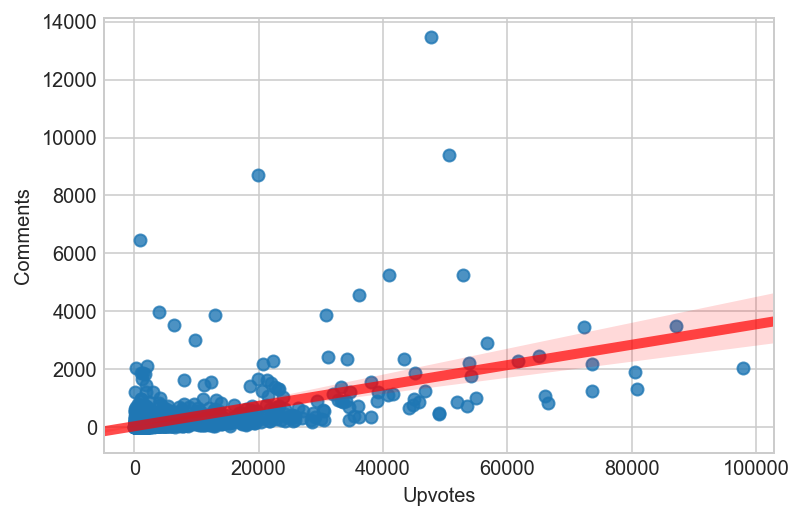

In [521]:
sns.regplot(x=reddit['Upvotes'], y=reddit['Comments'], 
            line_kws={"color":"r","alpha":0.7,"lw":5}) 

In [712]:
reddit.corr()

,Comments,Upvotes,Hour of Day,Hours,Work Day Hours,Late Night Hours,Morning Hours,Evening/Night Hours
Comments,1.000000,0.556326,-0.146058,0.032530,-0.078814,NaN,-0.041475,-0.065922
Upvotes,0.556326,1.000000,-0.217260,0.065958,-0.120154,NaN,-0.061699,-0.090229
Hour of Day,-0.146058,-0.217260,1.000000,-0.135623,0.665502,NaN,0.202534,0.339266
Hours,0.032530,0.065958,-0.135623,1.000000,0.219331,NaN,-0.186101,-0.086098
Work Day Hours,-0.078814,-0.120154,0.665502,0.219331,1.000000,NaN,-0.321652,-0.320681
Late Night Hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Morning Hours,-0.041475,-0.061699,0.202534,-0.186101,-0.321652,NaN,1.000000,0.655192
Evening/Night Hours,-0.065922,-0.090229,0.339266,-0.086098,-0.320681,NaN,0.655192,1.000000


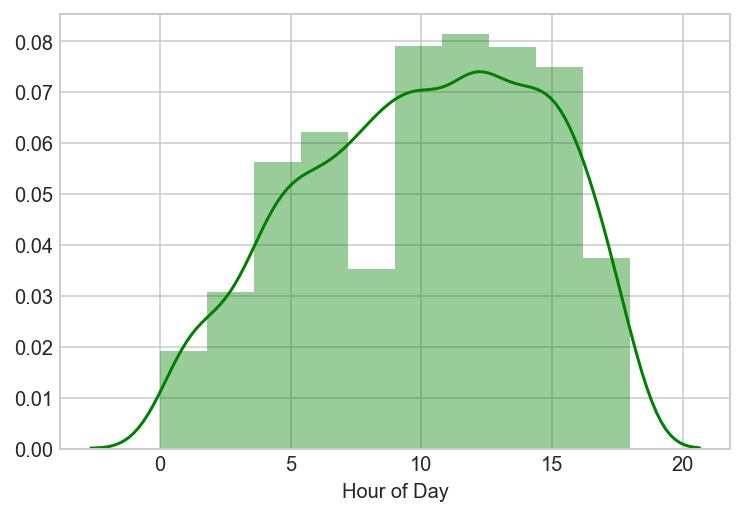

In [522]:
sns.distplot(reddit['Hour of Day'], kde=True, bins=10, color='green')

Interesting the highest number of Reddit posts seem to be uploaded during between 10am and 3pm, which is during regular work day hours and also a small peak in the morning around 4am to 7am. Those time ranges would be interesting to look at and see if those are "ideal" times of day to post something on Reddit.

By seeing the distribution of the number of upvotes. There are an inordinate amount of upvotes that are clsoer to zero than other outlying number of upvotes.

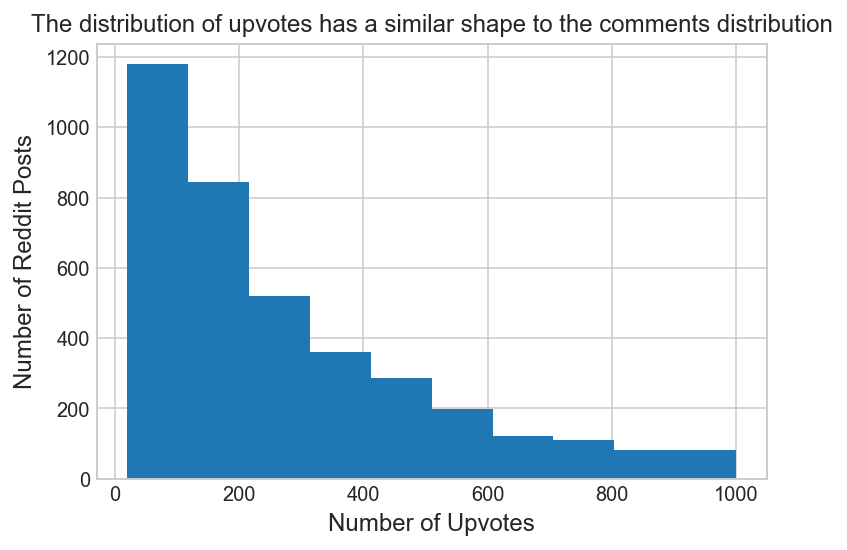

In [791]:
plt.hist(reddit['Upvotes'], range=(20,1000))
plt.xlabel('Number of Upvotes',fontsize='large')
plt.ylabel('Number of Reddit Posts',fontsize='large')
plt.title('The distribution of upvotes has a similar shape to the comments distribution', fontsize='large')
plt.show()

Same with the distribution of the number of comments for each Reddit post. There are an inordinate amount of posts that are closer to zero than other posts.

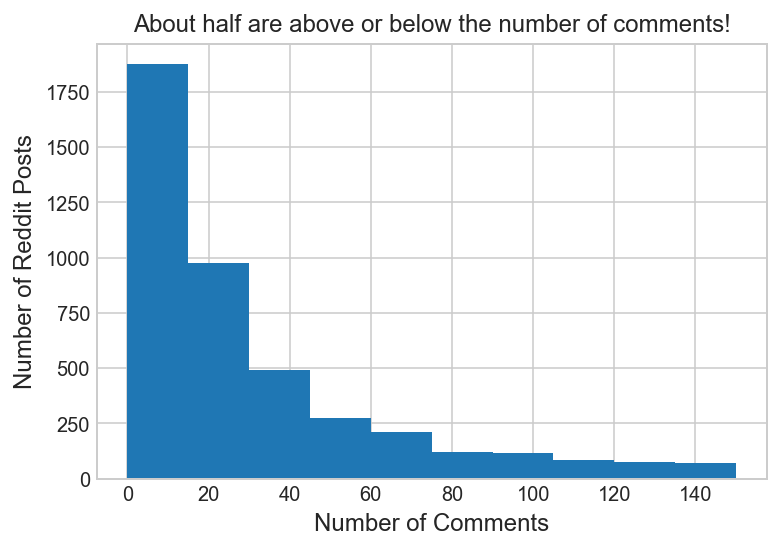

In [727]:
plt.hist(reddit['Comments'], range=(0,150))
plt.xlabel('Number of Comments',fontsize='large')
plt.ylabel('Number of Reddit Posts',fontsize='large')
plt.title('About half are above or below the number of comments!', fontsize='large')
plt.show()

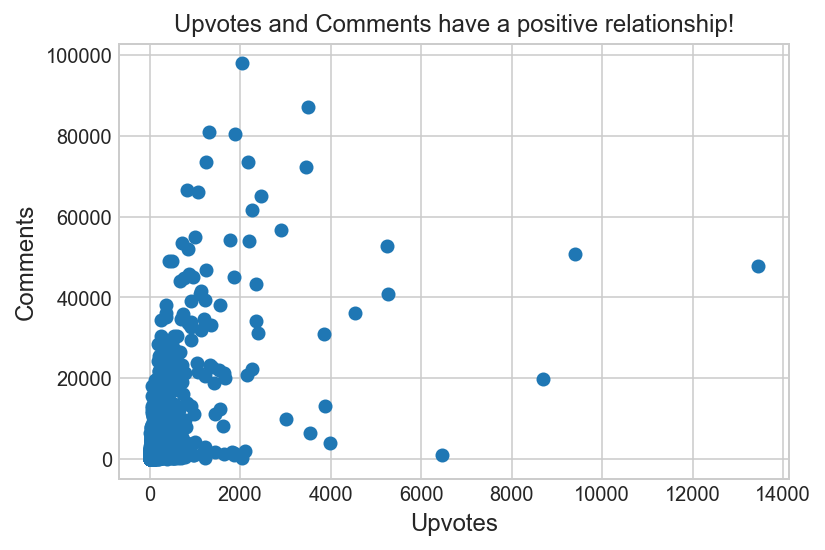

In [795]:
plt.scatter(reddit['Comments'], reddit['Upvotes'])
plt.xlabel('Upvotes',fontsize='large')
plt.ylabel('Comments',fontsize='large')
plt.title('Upvotes and Comments have a positive relationship!', fontsize='large')
plt.show()

### Natural Language Processing

In [606]:
X = reddit['Titles']
y = reddit['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [607]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cvec = CountVectorizer(stop_words='english', max_features=100)
tvec = TfidfVectorizer(stop_words='english', max_features=100)

In [608]:
cvecdata = cvec.fit_transform(X_train)
cvec_df  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

In [609]:
cvec_df.head(25)

,000,10,20,2018,ago,art,away,ban,beautiful,best,...,video,vs,want,way,week,won,work,world,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [610]:
tvec.fit(X_train)
tvec_df  = pd.DataFrame(tvec.transform(X_train).todense(),
                   columns=tvec.get_feature_names(),
                   index=[X_train])

In [611]:
tvec_df.head(25)

,000,10,20,2018,ago,art,away,ban,beautiful,best,...,video,vs,want,way,week,won,work,world,year,years
Titles,,,,,,,,,,,,,,,,,,,,,
New travel method,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
Average ELO of Overwatch community as shown by Jeff Kaplan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
TRUSTBUSTERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
[SFM] Scraptrap Jumpscare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
looming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
"Just one more video, me at 3:00am",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.804421,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
"""WoT Funny Moments"" Videos in a nutshell",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
People can't handle the truth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
The Army Is Officially Honoring Three Slain JROTC Cadets For Their Heroism During The Florida Shooting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


## Predicting comments using Random Forests + Another Classifier

In [612]:
reddit.head()

,Comments,Subreddits,Time,Titles,Upvotes,Above_Below_Median,Above_Below_Mean,Date Only,Hour of Day,Hours,Work Day Hours,Late Night Hours,Morning Hours,Evening/Night Hours
0,859,todayilearned,2018-02-20 20:21:01-05:00,TIL that comedian Ryan Stiles from Whose Line ...,51985,Above,Above,02-20-18,15,10,1,0,0,0
1,301,NintendoSwitch,2018-02-20 22:17:03-05:00,"Less 'rip and tear', more 'post and snark'...",8222,Above,Above,02-20-18,17,12,1,0,0,0
2,446,videos,2018-02-20 21:10:50-05:00,Heavy rain leaves trail under cristaline water...,10445,Above,Above,02-20-18,16,11,1,0,0,0
3,714,gaming,2018-02-20 20:25:42-05:00,Modern Warfare 2,18943,Above,Above,02-20-18,15,10,1,0,0,0
4,395,gifs,2018-02-20 20:00:19-05:00,Shocking Artistry...,25855,Above,Above,02-20-18,15,10,1,0,0,0


#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [694]:
X = pd.get_dummies(reddit['Subreddits'])
y = reddit['Above_Below_Median']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [695]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [696]:
forest = RandomForestClassifier(max_depth = 10, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.52518978605935129

#### So the model isn't bad. It is only performing slightly above 50. Let's do the same thing with a logistic regression!

### Logistic Regression

In [705]:
X = pd.get_dummies(reddit['Subreddits'])
y = reddit['Comments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.predict(X_test)

array([2, 2, 2, ..., 2, 2, 2])

This isn't great as the Random Forest classifier using the same variables for this model.

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [772]:
#Since a good chunk of Reddit posts are posted between 10am to 3pm and also in the morning, then I want to look to see
#if that, along with upvotes greatly predicts if it's above or below the median number of comments.
d
X = reddit[['Work Day Hours', 'Morning Hours', 'Upvotes']]
y = reddit['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [729]:
forest = RandomForestClassifier(max_depth = 10, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)    

0.71014492753623193

This is better than before! It seems to predict comments more accurately!

I want to look at the number of occurrences of the words in a title to predict comments.

In [627]:
combined = pd.concat([reddit, cvec_df], axis=1, join_axes=[reddit.index])

In [688]:
combined.iloc[:,18:] #only going to use the words and not the numbers

,ago,art,away,ban,beautiful,best,big,birthday,black,car,...,video,vs,want,way,week,won,work,world,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [710]:
X = combined.iloc[:,18:]
y = combined['Above_Below_Median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
forest = RandomForestClassifier(max_depth = 10, n_estimators=5, random_state=42)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)    

0.51897860593512768

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

I will use the evaluate_model function I created in the 4.04 Model Evaluation lab. This function calculates the confusion matrix, accuracy, sensitivity and specificity. In this situation for classification evaluation metrics, I would want to evaluate my models based on sensitivity, or the true positive rate, because among those that are actually above the median, I want to correctly predict as many of them as possible. But I wouldn't want to have such a low specificity that I miss all the false positives.

In [703]:
def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    tn = conf_matrix[0][0] #true negative
    tp = conf_matrix[1][1] #true positive
    fn = conf_matrix[1][0] #false negative 
    fp = conf_matrix[0][1] #false positive

    Accuracy = (tp + tn) / (tp + tn + fp + fn)
    Sensitivity = tp / (tp + fn)
    Specificity = tn / (tn + fp)
    
    return([conf_matrix, Accuracy, Sensitivity, Specificity])

##### Results interpretation

- Top left = number of true negatives
- Top Right = number of false positives
- Bottom left = number of false negatives
- Bottom right = number of true positives

- Accuracy - first floating number
- Sensitivity - second floating number
- Specificity - third floating number

### In this case, the positive is being above the median number of posts while negative is below the median number of comments.

### Our very first model: Random Forests using Subreddits only whether a post is above or below the median number of comments

In [704]:
from sklearn.metrics import confusion_matrix 
evaluate_model(X_train, X_test, y_train, y_test, forest)

[array([[ 58, 680],
        [  8, 703]]),
 0.52518978605935129,
 0.98874824191279886,
 0.078590785907859076]

It has a very high sensitivity, meaning that it measured the proportion of positives that are correctly identified very well. It is also called the true positive rate, basically meaning how good was the model in detecting the positives. It also means that the number of false negatives are so small that the true positive rate is almost 1. It also means that the model picks up almost all the positives, but since its specificity is so low, it won't be able to pick up a lot of the false positives. I do like that it predicts almost all the true positives among the actual positives, but if it has a very low specificity, I probably would to use this model.

### Evaluation of a Random Forest model using times of day and number of upvotes to predict comments

In [773]:
evaluate_model(X_train, X_test, y_train, y_test, forest)

[array([[528, 210],
        [210, 501]]),
 0.71014492753623193,
 0.70464135021097052,
 0.71544715447154472]

This model is much different than the previous model. The sensitivity and specificity are very similar, but are not 50-50, which would have meant that the model isn't good with discriminating from one class from another. The model does a pretty good job detecting the positives and negatives, although it is missing some false positives and false negatives.

### Evaluation of a Random Forest model using word occurrences to predict comments

In [711]:
evaluate_model(X_train, X_test, y_train, y_test, forest)

[array([[609, 129],
        [568, 143]]),
 0.51897860593512768,
 0.20112517580872011,
 0.82520325203252032]

This model is relatively the oppositive of the first model in terms of specificity and sensitivity. It has a high specificity and low sensitivity. It means it is able to detect more true negatives than false negatives than it is able to detect more true positives than false positives. I probably don't want to use this model if I want to maximize sensitivity.


# Executive Summary


Please refer to the README file associated with thie project. It is attached in the repository.